In [75]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision import tv_tensors
from torchvision.io import decode_image
import torchvision.models as models
from torchvision.ops import generalized_box_iou_loss
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from tqdm.auto import tqdm
import requests
import zipfile
import pathlib
from pathlib import Path
import shutil
import os
import pandas as pd
import numpy as np
import random
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold
from typing import Tuple, Dict, List
import sys
from timeit import default_timer as timer

# %load_ext autoreload
# %autoreload 1
# %aimport CarImageClass
import CarImageClass

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'laptop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"D:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"
train_path_simple = folder_path / "train_simple"
test_path_simple = folder_path / "test_simple"
train_path_oo = folder_path / "train_one_obj"
test_path_oo = folder_path / "test_one_obj"

In [76]:
train_data = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=None)

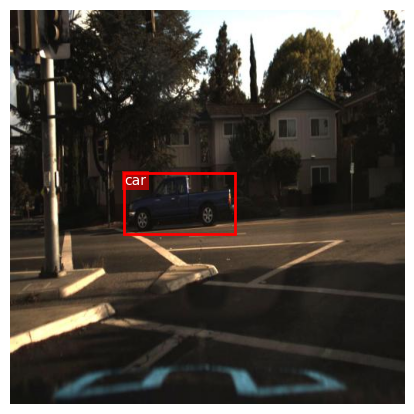

In [77]:
train_data.show_with_box(index=0, color='r', label=True)

In [78]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out
    

class XYXYHead(nn.Module):
    """
    Option B: predict (x1_hat, y1_hat, w_hat, h_hat)
      - x1, y1 ∈ [0, W/H] via sigmoid
      - w, h  > 0 via softplus
      - x2 = x1 + w, y2 = y1 + h
    If normalized=True, outputs are in [0,1] for x1,y1 and (0,1] for sizes; 
    otherwise scaled to pixels using img_wh.
    """
    def __init__(self, in_feats: int, hidden: int = 0, normalized: bool = True, min_size: float = 1e-6):
        super().__init__()
        self.normalized = normalized
        self.min_size = float(min_size)

        if hidden > 0:
            self.head = nn.Sequential(
                nn.Linear(in_feats, hidden),
                nn.ReLU(inplace=True),
                nn.Linear(hidden, 4),
            )
        else:
            self.head = nn.Linear(in_feats, 4)

    def forward(self, feats: torch.Tensor, img_wh=None, clamp_for_inference: bool = False):
        """
        feats:   (B, in_feats)
        img_wh:  None or (B, 2) tensor with [W, H] per sample (required if normalized=False)
        clamp_for_inference: if True, clamp final xyxy to image bounds (do NOT use during training)

        Returns:
            boxes_xyxy: (B, 4) with [x1, y1, x2, y2]
        """
        B = feats.size(0)
        raw = self.head(feats)                     # (B,4): [x1_hat, y1_hat, w_hat, h_hat]

        if self.normalized:
            # Predict in normalized space
            x1 = torch.sigmoid(raw[:, 0])          # [0,1]
            y1 = torch.sigmoid(raw[:, 1])          # [0,1]
            w  = torch.nn.functional.softplus(raw[:, 2]) + self.min_size   # (0,∞)
            h  = torch.nn.functional.softplus(raw[:, 3]) + self.min_size

            # Optionally keep sizes in [0,1] to avoid runaway boxes in normalized space
            # Uncomment if desired:
            # w = torch.sigmoid(raw[:, 2]).clamp_min(self.min_size)
            # h = torch.sigmoid(raw[:, 3]).clamp_min(self.min_size)

            # Convert to xyxy in normalized space
            x2 = x1 + w
            y2 = y1 + h

            boxes = torch.stack([x1, y1, x2, y2], dim=1)  # normalized
            if (not self.normalized) and (img_wh is not None):
                # dead branch by default; kept for symmetry
                pass

            # If you need pixel space later: multiply outside this module with img_wh
            if clamp_for_inference and img_wh is not None:
                W = img_wh[:, 0].unsqueeze(1)
                H = img_wh[:, 1].unsqueeze(1)
                boxes[:, [0, 2]] = boxes[:, [0, 2]].clamp(0, 1)
                boxes[:, [1, 3]] = boxes[:, [1, 3]].clamp(0, 1)
            return boxes

        else:
            # Pixel space: need img_wh
            assert img_wh is not None, "img_wh (B,2: [W,H]) required when normalized=False"
            W = img_wh[:, 0]
            H = img_wh[:, 1]

            x1 = torch.sigmoid(raw[:, 0]) * W      # [0, W]
            y1 = torch.sigmoid(raw[:, 1]) * H      # [0, H]
            w  = (torch.nn.functional.softplus(raw[:, 2]) + self.min_size) * W  # >0
            h  = (torch.nn.functional.softplus(raw[:, 3]) + self.min_size) * H  # >0

            x2 = x1 + w
            y2 = y1 + h

            boxes = torch.stack([x1, y1, x2, y2], dim=1)  # pixels

            if clamp_for_inference:
                # Only for eval/metrics/visualization. Do NOT clamp during training.
                boxes[:, 0] = boxes[:, 0].clamp(torch.Tensor([0]), W)  # x1
                boxes[:, 1] = boxes[:, 1].clamp(torch.Tensor([0]), H)  # y1
                boxes[:, 2] = boxes[:, 2].clamp(torch.Tensor([0]), W)  # x2
                boxes[:, 3] = boxes[:, 3].clamp(torch.Tensor([0]), H)  # y2

            return boxes



class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = XYXYHead(in_feats=512, hidden=0, normalized=False)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x, img_wh: torch.Tensor | None = None, clamp_for_inference: bool = False):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        feats = out.view(out.size(0), -1)                    # (B,512)
        boxes = self.fc(feats, img_wh=img_wh, clamp_for_inference=clamp_for_inference)
        return boxes

In [79]:
class SingleBoxRegressor(nn.Module):
    def __init__(self, pixel_count: int):
        """
        The image is transformed from 512 x 512 to pixel_count x pixel_count.
        """
        super().__init__()
        self.pixel_count = pixel_count
        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        in_f = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.backbone = backbone
        self.head = nn.Sequential(
            nn.Linear(in_f, pixel_count),
            nn.ReLU(inplace=True),
            nn.Linear(pixel_count, 4),    # a,b,c,d -> x1,y1,dx,dy
        )

    def forward(self, x):
        t = self.head(self.backbone(x))
        a, b, c, d = t.unbind(dim=1)

        x1 = a.sigmoid() * self.pixel_count               # in (0,pixel_count)
        y1 = b.sigmoid() * self.pixel_count
        dx = c.sigmoid() * (self.pixel_count - x1)        # in (0, pixel_count - x1]
        dy = d.sigmoid() * (self.pixel_count - y1)

        x2 = x1 + dx                                      # x2 ∈ [x1,pixel_count)
        y2 = y1 + dy
        return torch.stack([x1, y1, x2, y2], dim=1)

In [80]:
torch.manual_seed(42)
model_0 = SingleBoxRegressor(pixel_count=224).to(device)

model_0

SingleBoxRegressor(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [81]:
# random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pix_count = 224

# transforms
train_tfms = v2.Compose([
    v2.ToImage(),                                 # uint8 -> Tensor[C,H,W]
    v2.ToDtype(torch.float32, scale=True),        # to float in [0,1]
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((pix_count, pix_count)),                        # pick a fixed size for batching
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((pix_count, pix_count)),
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# training/testing data
train_data = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=train_tfms)
test_data = CarImageClass.ImageClass(targ_dir=test_path_oo, transform=test_tfms)


BATCH_SIZE = 16
# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              #num_workers=NUM_WORKERS,
                              )

test_dataloader = DataLoader(test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False, 
                             #num_workers=NUM_WORKERS,
                             )

model_0 = ResNet18().to(device)

In [82]:
image_batch, target_batch = next(iter(train_dataloader))

m0test = model_0(image_batch.to(device), img_wh = torch.ones((BATCH_SIZE, 2)) * 224, clamp_for_inference=True)

m0test[5]

tensor([129.7366, 141.6096, 224.0000, 224.0000], grad_fn=<SelectBackward0>)

In [83]:
target_batch['boxes'][5]

tensor([[119.8750, 111.1250, 129.5000, 119.0000]])

In [84]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device,
               clip_max_norm = 1):
    
    # put model in train mode
    model.train()

    # train loss, train accuracy values
    train_loss, train_acc = 0, 0

    # loop through data loader batches
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        for key in y.keys():
            y[key] = y[key].to(device)

        # forward pass
        B, _, H, W = X.shape
        img_wh = torch.ones((B, 2)) * pix_count
        y_pred = model(X, img_wh = img_wh, clamp_for_inference=False) # old: model(X)

        # calculate loss
        loss = loss_fn(y_pred, y['boxes'].squeeze(), reduction='mean')
        train_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad(set_to_none=True)

        # loss backward
        loss.backward()

        # optimizer step
        if clip_max_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
        
        optimizer.step()

        # calculate accuracy metric
        # y_pred_class = 
        # train_acc += (y_pred_class==y).sum().item()/(len(y_pred))

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [85]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # put model in eval mode
    model.eval()

    # test loss, test acc
    test_loss = 0
    test_acc = 0

    # turn on inference mode
    with torch.inference_mode():
        # loop through dataloader batches
        for batch, (X, y) in enumerate(dataloader):
            # send data to device
            X = X.to(device)
            for key in y.keys():
                y[key] = y[key].to(device)

            # forward pass
            B, _, H, W = X.shape
            img_wh = torch.ones((B, 2)) * H
            test_pred = model(X, img_wh = img_wh, clamp_for_inference=True) # old: model(X)

            # calculate loss
            loss = loss_fn(test_pred, y['boxes'].squeeze(), reduction='mean')
            test_loss += loss.item()

            # calculate accuracy
            # test_pred_labels = ??
            # test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
    
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [86]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler,
          loss_fn: torch.nn.Module,
          epochs: int = 5,
          device=device):
    
    # create results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
        
        test_loss, test_acc = test_step(model=model,
                                dataloader=test_dataloader,
                                loss_fn=loss_fn,
                                device=device)
        
        if scheduler is not None:
            scheduler.step()
        
        print(f"Epoch: {epoch}  |  Train loss: {train_loss:.4f}  |  Train accuracy: {train_acc:.4f}  |  Test loss: {test_loss:.4f}  |  Test accuracy: {test_acc:.4f}  ")

        # update results dictionary
        results['train_loss'].append(train_loss)
        results['test_loss'].append(test_loss)

    # return results
    return results

In [87]:
# random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pix_count = 224

# transforms
train_tfms = v2.Compose([
    v2.ToImage(),                                 # uint8 -> Tensor[C,H,W]
    v2.ToDtype(torch.float32, scale=True),        # to float in [0,1]
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((pix_count, pix_count)),                        # pick a fixed size for batching
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((pix_count, pix_count)),
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# training/testing data
train_data = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=train_tfms)
test_data = CarImageClass.ImageClass(targ_dir=test_path_oo, transform=test_tfms)


BATCH_SIZE = 16
# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              #num_workers=NUM_WORKERS,
                              )

test_dataloader = DataLoader(test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False, 
                             #num_workers=NUM_WORKERS,
                             )

# number of epochs
NUM_EPOCHS = 3

# model instantiation
# model_0 = SingleBoxRegressor(pixel_count=pix_count).to(device)
model_0 = ResNet18().to(device)

# setup loss function
loss_fn = generalized_box_iou_loss
optimizer = torch.optim.AdamW(params=model_0.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# start timer
start_time = timer()

# train model 0

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# end timer and print
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0  |  Train loss: 1.0038  |  Train accuracy: 0.0000  |  Test loss: 0.9813  |  Test accuracy: 0.0000  
Epoch: 1  |  Train loss: 0.9884  |  Train accuracy: 0.0000  |  Test loss: 0.9813  |  Test accuracy: 0.0000  
Epoch: 2  |  Train loss: 0.9840  |  Train accuracy: 0.0000  |  Test loss: 0.9847  |  Test accuracy: 0.0000  
Total training time: 1447.484 seconds


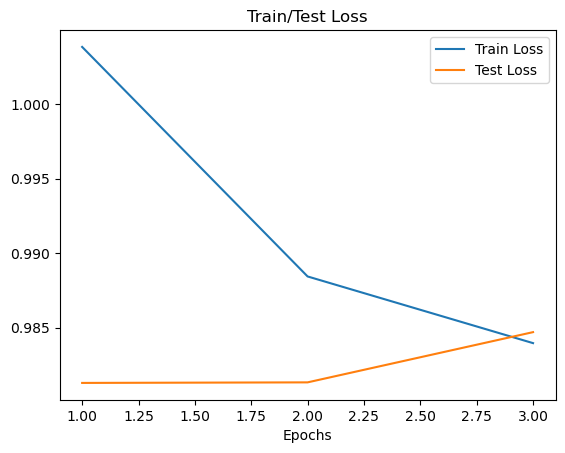

In [88]:
plt.plot(range(1, 1+NUM_EPOCHS), model_0_results["train_loss"], label="Train Loss")
plt.plot(range(1, 1+NUM_EPOCHS), model_0_results["test_loss"], label="Test Loss")
plt.title("Train/Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.show()

In [111]:
test_dataloader_pred = DataLoader(test_data, 
                             batch_size=1, 
                             shuffle=True, 
                             #num_workers=NUM_WORKERS,
                             )

test_sample_img, test_sample_target = next(iter(test_dataloader_pred))

test_sample_img = test_sample_img.to(device)
for key in test_sample_target.keys():
    test_sample_target[key] = test_sample_target[key].to(device)


test_sample_target['image_id']

tensor([[342]], device='cuda:0')

In [112]:
model_0.eval()
with torch.inference_mode():
    test_pred_output = model_0(test_sample_img)

test_pred_output

tensor([[  2.3562,  90.5286, 220.8131, 162.2442]], device='cuda:0')

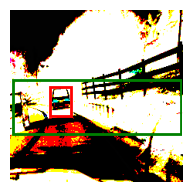

In [174]:
test_dataloader_pred = DataLoader(test_data, 
                             batch_size=1, 
                             shuffle=True, 
                             #num_workers=NUM_WORKERS,
                             )

test_sample_img, test_sample_target = next(iter(test_dataloader_pred))

test_sample_img = test_sample_img.to(device)
for key in test_sample_target.keys():
    test_sample_target[key] = test_sample_target[key].to(device)


idx = test_sample_target['image_id']
model_0.eval()
with torch.inference_mode():
    test_pred_output = model_0(test_sample_img).to('cpu')


test_data.show_with_box(index=idx, color='r', pred_box=True, bbox_pred=test_pred_output)